In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Fantasy-Premier-League/data/2021-22/gws/merged_gw.csv",index_col = 0)

In [4]:
df.columns

Index(['position', 'team', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [5]:
df2 = df[['xP','bps','minutes']].copy()
df2 = df2.reset_index()

In [6]:
names = df2['name'].unique()

In [7]:
list =[]
for name in names:
    temp = df2[df2['name']==name]
    xP = np.sum(temp['xP'])
    bps = np.sum(temp['bps'])
    minutes = np.sum(temp['minutes'])
    if minutes >= 1600:
        list.append([name,xP,bps])
df1 = pd.DataFrame(list, columns=['name', 'total_xP','total_bps'])

In [8]:
from sklearn import linear_model
linear_regression = linear_model.LinearRegression()
X = df1.iloc[:, 1].values.reshape(-1, 1)
Y = df1.iloc[:, 2].values.reshape(-1, 1)
linear_regression.fit(X,Y)
Y_pred = linear_regression.predict(X)

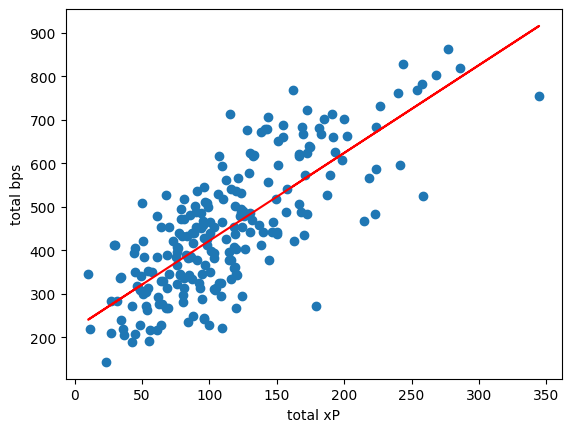

In [9]:
plt.scatter(X,Y)
plt.plot(X,Y_pred,color='red')
plt.xlabel('total xP')
plt.ylabel('total bps')
plt.show()

PCR r-squared 0.448


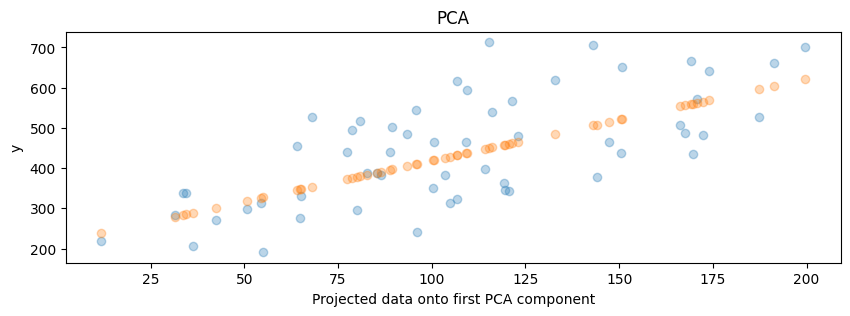

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(X, Y)
pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

fig, axes = plt.subplots(1, 1, figsize=(10, 3))
axes.scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes.scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes.set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCA"
)
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")

In [41]:
df3 = df.loc[df['minutes'] != 0]
y = df3['bps']
X = df3.drop(['bps', 'position','team','kickoff_time'], axis=1)
train, test = train_test_split(X, test_size=0.2)

In [42]:
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from sklearn import preprocessing
y = y.values
X = X.values

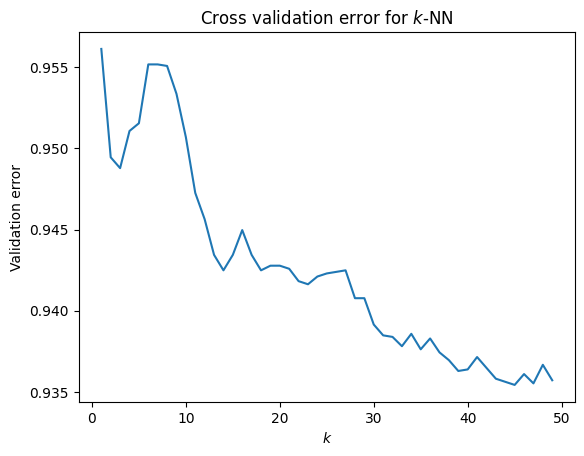

In [16]:
# Set random seed for reproducibility
np.random.seed(1)

# K-Folds cross-validator for preprocessing with StandardScaler
n_fold = 10
k_values = np.arange(1,50)
cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)
misclassification_rates = np.zeros(len(k_values))
variance = np.zeros(len(k_values))

# Loop through the cross-validation folds
for train_index, val_index in cv.split(X):
    # Get train and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    # Loop through different values of k
    for j,k in enumerate(k_values):
        # Train a KNN model with the current value of k
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        # Make predictions on the validation set
        y_pred = model.predict(X_val)
        # Calculate and store the misclassification rate for this value of k
        misclassification_rates[j] += np.mean(y_pred != y_val)
misclassification_rates /= n_fold

# Plot cross-validation error for each k value
plt.figure(1)
plt.plot(k_values, misclassification_rates)
plt.title('Cross validation error for $k$-NN')
plt.xlabel('$k$')
plt.ylabel('Validation error')
plt.show()

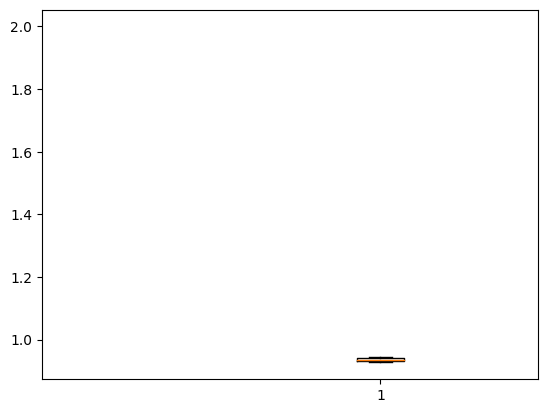

Mean 0.9359090627933545
Variance 2.5891638593368825e-05
Optimal k 45


In [18]:
# Select optimal k value based on minimum cross-validation error
optimal_k = k_values[np.argmin(misclassification_rates)]

model = skl_nb.KNeighborsClassifier(n_neighbors=optimal_k)

misclassification  = np.zeros(n_fold)
cv = skl_ms.KFold(n_splits=n_fold, random_state=1, shuffle=True)


for i, (train_index, val_index) in enumerate(cv.split(pd.DataFrame(X))):
    X_train, X_val = pd.DataFrame(X).iloc[train_index], pd.DataFrame(X).iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    misclassification[i] += np.mean(pred != y_val)
plt.plot(2)
plt.boxplot(misclassification)
plt.show()
print(f'Mean {np.mean(misclassification)}')
print(f'Variance {np.var(misclassification)}')
print(f'Optimal k {optimal_k}')

Error rate for LDA: 0.8243204577968527


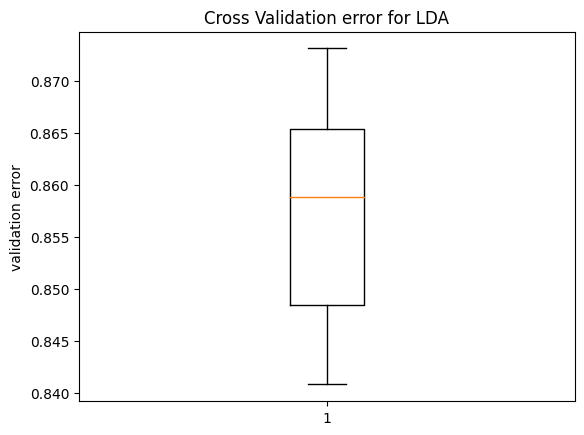

Variance of LDA: 0.00010072402823986491


In [46]:
import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
#LDA: Using the skl_da to calculate the Linear Discriminant Analysis error rate
model = skl_da.LinearDiscriminantAnalysis()
model.fit(X, y)
prediction = model.predict(X)
err = np.mean(prediction != y)
print('Error rate for LDA: ' + str(err))
#Calculating a 10-fold cross-validation 
n_fold = 10

models = []
models.append(skl_da.LinearDiscriminantAnalysis())

misclassification = np.zeros((n_fold, len(models)))
cv = skl_ms.KFold(n_splits=n_fold, random_state=1, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    for m in range(np.shape(models)[0]):
        model = models[m]
        model.fit(X_train, y_train)
        prediction = model.predict(X_val)
        misclassification[i, m] = np.mean(prediction != y_val)

#Plot the Cross validation errors 
plt.boxplot(misclassification)
plt.title('Cross Validation error for LDA')
plt.ylabel('validation error')
plt.show()

#Finding the variance for the misclassification of LDA
Var1 = np.var(misclassification[:,0])
print('Variance of LDA: ' + str(Var1))

In [53]:
#from here on the same code as before
np.random.seed(2) 
components=X.shape[1]
#performing k-fold
n_fold=10                               
cv=skl_ms.KFold(n_splits=n_fold, random_state=2,shuffle=True)

#initializing variables for missclassification error and calculated coefficients in the method
missclassvec=np.zeros(n_fold)
missclass=0
coef=np.zeros((1,components))

#setting the model
model=skl_lm.LogisticRegression(solver='liblinear',penalty='l2',C=1)
#model=skl_lm.LogisticRegression(solver='newton-cg', penalty='l2',C=1)
#model=skl_lm.LogisticRegression(solver='sag', penalty='l2')
#model=skl_lm.LogisticRegression(solver='saga', penalty='elasticnet')
i=0
#each step of the for-loop is one iteration of k-folding, logistic regression is performed in each iteration
for train_index, val_index in cv.split(X):
    X_train, X_val=X[train_index], X[val_index]
    y_train, y_val=y[train_index], y[val_index]
    model.fit(X_train,y_train)      #logistic regression is performed on the train data 
    prediction=model.predict(X_val) #prediction is done on the validation data
    missclassvec[i]=np.mean(prediction!=y_val)
    missclass+=missclassvec[i]
    i+=1
    

#calculating averged missclassification error
missclass/=n_fold
print(missclass)

#calculating variance in missclassification error
print(np.var(missclassvec))

C:\Users\99vik\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\99vik\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\99vik\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\99vik\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\99vik\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\99vik\AppData\Roaming\Python\Python3

0.8906045561385254
5.120416781057487e-05


C:\Users\99vik\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
